<a href="https://colab.research.google.com/github/elemi10/7506-TP-Org-de-datos/blob/7506-Trabajo-Practico-1/TP1_7506_Org_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TP1 - Real or Not?**

###  **Análisis exploratorio**

![Banner_TP1.png](https://drive.google.com/uc?id=1BPA2RF1SDm9bTs1xZfVUa1VQn932E3wr)


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1RAGDjlzJ6spO5Sq8_x3UTIvxLhKAUBEt'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.csv') 

### Importamos **Librerias**

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime as dt
import scipy as sp
#from sklearn.cross_validation import train_test_split -- no levanta
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,9)
plt.style.use('default') # mejoramos esteticamente un poco los gráficos en matplotlib
sns.set(style='whitegrid') # seteando tipo de grid en seaborn

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
#from sklearn.metrics import confusion_matrix
#from sklearn.naive_bayes import GaussianNB
#from sklearn.metrics import classification_report
#from sklearn.feature_selection import SelectKBest
#from sklearn.cross_validation import train_test_split --> No levanta el feature de la libreria

### Levantramos el archivo **train.csv**

In [75]:
df_train = pd.read_csv(r'train.csv', usecols=['keyword','location','text','target']) 
df_train.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Preprocesamiento de datos

In [76]:
# Verifico que no haya instancias nulas o filas completas nulas
df_train=df_train.dropna(how="all")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [77]:
# Normalizo el dataframe los registros NaN con texto
df_train=df_train.fillna({'keyword': 'sin keyword',\
                   'location': 'sin location'})
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7613 non-null   object
 1   location  7613 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [78]:
# Eliminamos los tweets duplicados considerando que su cantidad no tiene impacto en el análisis.
df_train=df_train.drop_duplicates('text')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7503 non-null   object
 1   location  7503 non-null   object
 2   text      7503 non-null   object
 3   target    7503 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 293.1+ KB


In [79]:
# Verificamos la existencia de valores nulos
df_train.isnull().any()

keyword     False
location    False
text        False
target      False
dtype: bool

**→ Creamos una serie que hace el conteo de la cant de caracteres del tweet**

In [80]:
# Creo una columna con el cálculo de las palabras que tiene la columna 'text' y la llamo 'caracteres_tweet'. 
# Despues consulto con un head()
df_train['caracteres_tweet']=df_train['text'].str.len()
df_train.head(2)

,keyword,location,text,target,caracteres_tweet
0,sin keyword,sin location,Our Deeds are the Reason of this #earthquake M...,1,69
1,sin keyword,sin location,Forest fire near La Ronge Sask. Canada,1,38


### Cálculo de **estadísticas básicas**

In [81]:
# Calculamos unas estadisticas basicas
df_train.describe()

,target,caracteres_tweet
count,7503.000000,7503.000000
mean,0.426230,100.880581
std,0.494561,33.819457
min,0.000000,7.000000
25%,0.000000,77.000000
50%,0.000000,107.000000
75%,1.000000,133.000000
max,1.000000,157.000000


In [82]:
#Calculo el promedio y lo asigno a la variable 'df_short_mean'
df_train_mean=np.round(df_train['caracteres_tweet'].mean(), decimals=2)
df_train_mean

100.88

In [83]:
# Calculo la mediana, para tener presente como impacta max() y min() en la distribución
df_train_median=np.round(df_train['caracteres_tweet'].median(), decimals=2)
df_train_median

107.0

In [84]:
# cuento total de tweets analizados
total_tweets=len(df_train)
total_tweets

7503

In [85]:
# verifico cuantos son verdaderos
tweets_verdaderos=(df_train['target']==1).sum()
tweets_verdaderos

3198

In [86]:
# verifico cuantos son fakes
tweets_falsos=(df_train['target']==0).sum()
tweets_falsos

4305

In [87]:
# calculo la probabilidad (casos favorables/sobre casos posibles) → en este casos es equivalente .mean()
probabilidad_tweet_verdadero = np.round((tweets_verdaderos)/(total_tweets),decimals=5)
probabilidad_tweet_verdadero

0.42623

In [88]:
# calculo la probabilidad (casos favorables/sobre casos posibles) → en este casos es equivalente .mean()
probabilidad_tweet_falso = np.round((tweets_falsos)/(total_tweets),decimals=2)
probabilidad_tweet_falso

0.57

**→ Asignación de variables para cálculos**

In [89]:
# Asigno a variables para que se puedan operar alfabéticamente
tweets_verdaderos=df_train['target']==1
tweets_verdaderos.head()
# Verifico cantidad de tweets verdaderos
tweets_verdaderos.sum()

3198

In [90]:
# Aplico la misma acción para tweets fakes
# verifico cantidad de tweets fakes
tweets_fake=df_train['target']==0
tweets_fake.head()
tweets_fake.sum()

4305

In [91]:
# Asigno a la variable 'tweets_mayor_promedio', los tweets que tienen un promedio en cant de registros > Promedio (de caracteres de tweets del DF)
# Me va a servir para ver mas adelante como es su distribución
tweets_mayor_promedio=df_train['caracteres_tweet']>=(df_train_mean)
# Hago un .head() para verificar para despues hacer la suma de tweets con una cant de caracteres mayor al promedio
print(tweets_mayor_promedio.head())
tweets_mayor_promedio.sum()

0    False
1    False
2     True
3    False
4    False
Name: caracteres_tweet, dtype: bool


4141

In [92]:
# Lo mismo que el apartado anterior, con la diferencia que traigo en la variable 'tweets_menor_promedio' 
# aquellos registros que son menor al promedio
tweets_menor_promedio=df_train['caracteres_tweet']<(df_train_mean)
tweets_menor_promedio.sum()

3362

In [93]:
# Por un tema de comodidad, creo una nueva columna con la referencia al valor booleano de la variable 'target'.
# 0=tweet falso | 1=tweet verdadero
df_train['tweet_type']=np.where(df_train['target']==1,"tweet verdadero","tweet falso")
df_train.head(2)

,keyword,location,text,target,caracteres_tweet,tweet_type
0,sin keyword,sin location,Our Deeds are the Reason of this #earthquake M...,1,69,tweet verdadero
1,sin keyword,sin location,Forest fire near La Ronge Sask. Canada,1,38,tweet verdadero


In [94]:
# Reverifico
pd.value_counts(df_train['tweet_type'])

tweet falso        4305
tweet verdadero    3198
Name: tweet_type, dtype: int64

In [95]:
# Armo una tabla de frecuencia de las variables
100*df_train['tweet_type'].value_counts()/len(df_train['tweet_type'])

tweet falso        57.377049
tweet verdadero    42.622951
Name: tweet_type, dtype: float64

In [96]:
# Agrego una categoría para agrupar por promedio
df_train['avg_category']=np.where(df_train['caracteres_tweet']>=(df_train_mean)\
                                  ,"tw w/characts.above AVG ocurrs.","tw w/characts.below AVG ocurrs") 
df_train.head()

,keyword,location,text,target,caracteres_tweet,tweet_type,avg_category
0,sin keyword,sin location,Our Deeds are the Reason of this #earthquake M...,1,69,tweet verdadero,tw w/characts.below AVG ocurrs
1,sin keyword,sin location,Forest fire near La Ronge Sask. Canada,1,38,tweet verdadero,tw w/characts.below AVG ocurrs
2,sin keyword,sin location,All residents asked to 'shelter in place' are ...,1,133,tweet verdadero,tw w/characts.above AVG ocurrs.
3,sin keyword,sin location,"13,000 people receive #wildfires evacuation or...",1,65,tweet verdadero,tw w/characts.below AVG ocurrs
4,sin keyword,sin location,Just got sent this photo from Ruby #Alaska as ...,1,88,tweet verdadero,tw w/characts.below AVG ocurrs


In [97]:
# Relaciono las variables con una tabla de contingencia (%)
pd.crosstab(index=df_train['tweet_type'], columns=df_train['avg_category'], \
            margins=True).apply(lambda x:x/len(df_train)*100,axis=1)

avg_category,tw w/characts.above AVG ocurrs.,tw w/characts.below AVG ocurrs,All
tweet_type,,,
tweet falso,28.708517,28.668533,57.377049
tweet verdadero,26.482740,16.140211,42.622951
All,55.191257,44.808743,100.000000


### Gráfico **Overlaid Density Plots** [Distribución]

Text(0, 0.5, 'Densidad')

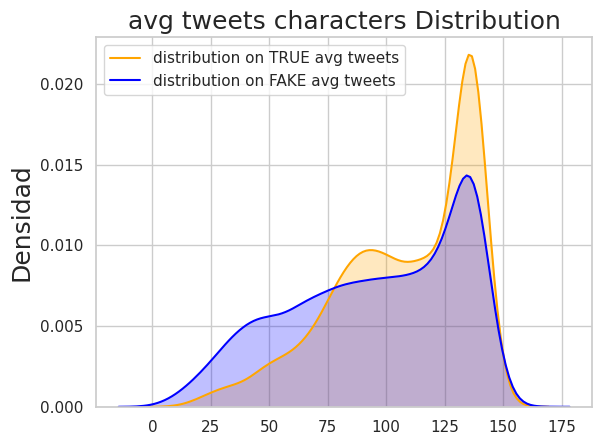

In [140]:
# grafico de tabla de contingencia de los tweets falsos vs tweets v en funcion del promedio de caracteres
graph_distrb=sns.kdeplot(df_train[df_train['tweet_type']=="tweet verdadero"]['caracteres_tweet'],\
                         color="orange", label="distribution on TRUE avg tweets", shade=True)

graph_distrb=sns.kdeplot(df_train[df_train['tweet_type']=="tweet falso"]['caracteres_tweet'], \
                         color="blue", label="distribution on FAKE avg tweets", shade=True)

graph_distrb.set_title("avg tweets characters Distribution", fontsize=18)
graph_distrb.set_ylabel("Densidad", fontsize=18)

### **Análisis & tokenización**

In [0]:
# Función de tokenización
import string
punctuation = set(string.punctuation)

def tokenize(sentence):
    tokens = []
    for token in sentence.split():
        new_token = []
        for character in token:
            if character not in punctuation:
                new_token.append(character.lower())
        if new_token:
            tokens.append("".join(new_token))
    return tokens

In [100]:
# Creo la serie 'text_vector'
df_train['text_vector']=df_train['text'].apply(tokenize)
df_train.head(2)

,keyword,location,text,target,caracteres_tweet,tweet_type,avg_category,text_vector
0,sin keyword,sin location,Our Deeds are the Reason of this #earthquake M...,1,69,tweet verdadero,tw w/characts.below AVG ocurrs,"[our, deeds, are, the, reason, of, this, earth..."
1,sin keyword,sin location,Forest fire near La Ronge Sask. Canada,1,38,tweet verdadero,tw w/characts.below AVG ocurrs,"[forest, fire, near, la, ronge, sask, canada]"


In [101]:
# Verifico integridad de DF
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   keyword           7503 non-null   object
 1   location          7503 non-null   object
 2   text              7503 non-null   object
 3   target            7503 non-null   int64 
 4   caracteres_tweet  7503 non-null   int64 
 5   tweet_type        7503 non-null   object
 6   avg_category      7503 non-null   object
 7   text_vector       7503 non-null   object
dtypes: int64(2), object(6)
memory usage: 527.6+ KB


In [102]:
# Descargo e importo lista de stopwords para filtrar
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [103]:
from nltk.corpus import stopwords
stopwords.fileids()

['arabic',
 'azerbaijani',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [0]:
# Asigno en la variable 'stop' la categoria de stopword por la que voy a realizar el filtro
stop=stopwords.words('english')

In [0]:
def filtro(text_vector):
  text_vector_filtrado = []
  for palabra in text_vector:
    if palabra not in stop:
      text_vector_filtrado.append(palabra)
  return(text_vector_filtrado)

In [106]:
# Tokens filtrados por stopwords en inglés
df_train['text_vector_filtrado']=df_train['text_vector'].apply(filtro)
df_train['text_vector_filtrado'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [13000, people, receive, wildfires, evacuation...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text_vector_filtrado, dtype: object

In [107]:
# Asigno en una nueva columna el largo del vector 'text_vector'
df_train['elem_vector']=df_train['text_vector'].str.len()
df_train.head(2)

,keyword,location,text,target,caracteres_tweet,tweet_type,avg_category,text_vector,text_vector_filtrado,elem_vector
0,sin keyword,sin location,Our Deeds are the Reason of this #earthquake M...,1,69,tweet verdadero,tw w/characts.below AVG ocurrs,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",13
1,sin keyword,sin location,Forest fire near La Ronge Sask. Canada,1,38,tweet verdadero,tw w/characts.below AVG ocurrs,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",7


In [108]:
# Cuento los elementos del vector filtrado 'text_vector_filtrado'
df_train['elem_vector_filtrado']=df_train['text_vector_filtrado'].str.len()
df_train.head(2)

,keyword,location,text,target,caracteres_tweet,tweet_type,avg_category,text_vector,text_vector_filtrado,elem_vector,elem_vector_filtrado
0,sin keyword,sin location,Our Deeds are the Reason of this #earthquake M...,1,69,tweet verdadero,tw w/characts.below AVG ocurrs,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",13,7
1,sin keyword,sin location,Forest fire near La Ronge Sask. Canada,1,38,tweet verdadero,tw w/characts.below AVG ocurrs,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",7,7


In [109]:
# Verifico estructura del DF
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   keyword               7503 non-null   object
 1   location              7503 non-null   object
 2   text                  7503 non-null   object
 3   target                7503 non-null   int64 
 4   caracteres_tweet      7503 non-null   int64 
 5   tweet_type            7503 non-null   object
 6   avg_category          7503 non-null   object
 7   text_vector           7503 non-null   object
 8   text_vector_filtrado  7503 non-null   object
 9   elem_vector           7503 non-null   int64 
 10  elem_vector_filtrado  7503 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 703.4+ KB


### Preproceso y categorización de la variable ***Keyword***

In [110]:
# "Limpiamos" la serie de caracteres especiales
df_train['keyword']=df_train['keyword'].str.replace('%20','_')
# Verificamos actualización
df_train['keyword'].unique()

array(['sin keyword', 'ablaze', 'accident', 'aftershock',
       'airplane_accident', 'ambulance', 'annihilated', 'annihilation',
       'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack',
       'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism',
       'blaze', 'blazing', 'bleeding', 'blew_up', 'blight', 'blizzard',
       'blood', 'bloody', 'blown_up', 'body_bag', 'body_bagging',
       'body_bags', 'bomb', 'bombed', 'bombing', 'bridge_collapse',
       'buildings_burning', 'buildings_on_fire', 'burned', 'burning',
       'burning_buildings', 'bush_fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical_emergency', 'cliff_fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailmen

### Generación de **diccionario**

In [111]:
# Listo para generar un diccionario y traducir la serie 'keyword'
keyword_list=df_train['keyword'].unique().tolist()
print(keyword_list)

['sin keyword', 'ablaze', 'accident', 'aftershock', 'airplane_accident', 'ambulance', 'annihilated', 'annihilation', 'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze', 'blazing', 'bleeding', 'blew_up', 'blight', 'blizzard', 'blood', 'bloody', 'blown_up', 'body_bag', 'body_bagging', 'body_bags', 'bomb', 'bombed', 'bombing', 'bridge_collapse', 'buildings_burning', 'buildings_on_fire', 'burned', 'burning', 'burning_buildings', 'bush_fires', 'casualties', 'casualty', 'catastrophe', 'catastrophic', 'chemical_emergency', 'cliff_fall', 'collapse', 'collapsed', 'collide', 'collided', 'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge', 'deluged', 'demolish', 'demolished', 'demolition', 'derail', 'derailed', 'derailment', 'desolate', 'desolation', 'destroy', 'destroyed', 'destruction', 'detonate', 'detonation', 'devastat

In [112]:
#1 Genero lista en espaniol
keyword_list_esp=['sin_keyword','en llamas','accidente','replica','accidente_avion','ambulancia','aniquilado','aniquilacion','apocalipse','armageddon','ejercito','incendio_intencional','piromano','ataque','atacado','avalancha','combate/batalla/lucha','bioterror','bioterrorismo','resplandecer/arder','resplandeciente/ardiente','hemorragia','exploto','plaga','ventisca','sangre','sangriento','estallido','bolsa_de_cadaver','embolsado_de_cadaver','bolsas_de_cadaver','bomba','bombardeado','bombardeo','colapso_de_puente','incendio_de_edificios','edificios_en_llamas','quemado','quemando/incendiando','incendio_edificios','incendio_de_matorrales/arbustos','bajas/muertes/perdidas','baja/muerte/perdida','catastrofe','catastrofico','emergencia_quimica','caida_acantilado','colapso','colapsado','colisionar','colisiono','colision','choque','estrellado','aplastamiento','aplastado','toque_de_queda','ciclon','da¤o','peligro','muerto','muerte','muertes','escombros','diluvio','inundado','demoler','demolido','demolicion','descarrilar','descarrilado','descarrilamiento','desolado','desolacion','destruir','destruido','destruccion','detonado','detonacion','devastado','devastacion','desastre','dislacado/desplazado','sequia','ahogar','ahogado','ahogamiento/ahogandose','tormenta_polvo','terremoto','electrocutar','electrocutado','emergencia','plan_de_emergencia','servicio_de_emergencia','engullido','epicentro','evacuar','evacuado','evacuacion','explotar','exploto/detonado/estallado','explosion','testigo_ocular','hambruna','fatal','fatalidades','fatalidades','miedo','fuego','camion_bombero','primeros_en_responder','llamas','aplastado','inundacion','inundaciones','inundaciones','incendio_forestal','incendio_forestales','granizo','tormenta_granizo','da¤o','peligro','peligroso','ola_de_calor','infierno','secuestro','secuestrador','secuestro','rehen','rehenes','huracan','herido/lesionado','heridas/lesiones','herida/lesion','inundado','inundacion','deslisamiento_tierra','lava','rayo','golpe_fuerte/estampido_fuerte','asesinato_en_serie','asesino_en_serie','masacre','caos','fusion','militar','alud_de_lodo','desastre_natural','desastre_nuclear','reactor_nuclear','obliterar/destruir/eliminar','borrado/destruido/eliminado','obliteracion/destruccion/eliminacion','derrame_de_petroleo','brote','pandemonio/confusion/caos','panico','tener_panico','polic¡a','cuarentena','en_cuarentena','emergencia_radiacion','tormenta','arrasado','refugiados','rescate','rescatado','rescatadores','disturbio','disturbios','escombros','ruina','tormenta_de_arena','grito','gritando','gritos','sismico','sumidero/pozo','hundiendose','sirena','sirenas','humo','tormenta_de_nieve','tormenta','camilla','fallo_estructural','bomba_suicida','suicida','bombardeo_suicida','hundido','sobrevivir','sobrevivio','sobreviviente','terrorismo','terrorista','amenaza','trueno','tormenta_electrica','tornado','tragedia','atrapado','trauma','traumatizado','problema','tsunami','tornado/torbellino','tifon','transtorno','tormenta_violenta','volcan','zona_de_guerra','arma','armas','torbellino','incendios_forestales','incendio_forestal','tormenta_de_viento','moretoneado','moretones','naufragio','restos','naufrago']
print(keyword_list_esp)

['sin_keyword', 'en llamas', 'accidente', 'replica', 'accidente_avion', 'ambulancia', 'aniquilado', 'aniquilacion', 'apocalipse', 'armageddon', 'ejercito', 'incendio_intencional', 'piromano', 'ataque', 'atacado', 'avalancha', 'combate/batalla/lucha', 'bioterror', 'bioterrorismo', 'resplandecer/arder', 'resplandeciente/ardiente', 'hemorragia', 'exploto', 'plaga', 'ventisca', 'sangre', 'sangriento', 'estallido', 'bolsa_de_cadaver', 'embolsado_de_cadaver', 'bolsas_de_cadaver', 'bomba', 'bombardeado', 'bombardeo', 'colapso_de_puente', 'incendio_de_edificios', 'edificios_en_llamas', 'quemado', 'quemando/incendiando', 'incendio_edificios', 'incendio_de_matorrales/arbustos', 'bajas/muertes/perdidas', 'baja/muerte/perdida', 'catastrofe', 'catastrofico', 'emergencia_quimica', 'caida_acantilado', 'colapso', 'colapsado', 'colisionar', 'colisiono', 'colision', 'choque', 'estrellado', 'aplastamiento', 'aplastado', 'toque_de_queda', 'ciclon', 'da¤o', 'peligro', 'muerto', 'muerte', 'muertes', 'escomb

In [113]:
#1 Genero el diccionario eng-esp de la serie 'Keyword'
keyword_dicc={}
y=0
for x in keyword_list:
  keyword_dicc[x]=keyword_list_esp[y]
  y=y+1
  #print(keyword_dicc)

print(keyword_dicc)

{'sin keyword': 'sin_keyword', 'ablaze': 'en llamas', 'accident': 'accidente', 'aftershock': 'replica', 'airplane_accident': 'accidente_avion', 'ambulance': 'ambulancia', 'annihilated': 'aniquilado', 'annihilation': 'aniquilacion', 'apocalypse': 'apocalipse', 'armageddon': 'armageddon', 'army': 'ejercito', 'arson': 'incendio_intencional', 'arsonist': 'piromano', 'attack': 'ataque', 'attacked': 'atacado', 'avalanche': 'avalancha', 'battle': 'combate/batalla/lucha', 'bioterror': 'bioterror', 'bioterrorism': 'bioterrorismo', 'blaze': 'resplandecer/arder', 'blazing': 'resplandeciente/ardiente', 'bleeding': 'hemorragia', 'blew_up': 'exploto', 'blight': 'plaga', 'blizzard': 'ventisca', 'blood': 'sangre', 'bloody': 'sangriento', 'blown_up': 'estallido', 'body_bag': 'bolsa_de_cadaver', 'body_bagging': 'embolsado_de_cadaver', 'body_bags': 'bolsas_de_cadaver', 'bomb': 'bomba', 'bombed': 'bombardeado', 'bombing': 'bombardeo', 'bridge_collapse': 'colapso_de_puente', 'buildings_burning': 'incendio_

In [114]:
# Mapeo los valores de las key del diccionario keyword_dicc
df_train['keyword_esp']=df_train['keyword'].map(keyword_dicc)
df_train.head(2)

,keyword,location,text,target,caracteres_tweet,tweet_type,avg_category,text_vector,text_vector_filtrado,elem_vector,elem_vector_filtrado,keyword_esp
0,sin keyword,sin location,Our Deeds are the Reason of this #earthquake M...,1,69,tweet verdadero,tw w/characts.below AVG ocurrs,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",13,7,sin_keyword
1,sin keyword,sin location,Forest fire near La Ronge Sask. Canada,1,38,tweet verdadero,tw w/characts.below AVG ocurrs,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",7,7,sin_keyword


In [115]:
# Verifico el top 20 de las categorias mas frecuentes para la serie keyword 
df_train['keyword_esp'].value_counts().sort_values(ascending=False).head(20)

fatalidades           82
da¤o                  82
inundaciones          72
peligro               70
tormenta              69
escombros             65
aplastado             65
secuestro             64
inundado              62
sin_keyword           56
incendio_forestal     52
inundacion            45
diluvio               42
armageddon            42
bolsas_de_cadaver     41
evacuar               40
tornado/torbellino    40
sirena                40
tormenta_de_viento    40
miedo                 40
Name: keyword_esp, dtype: int64

In [116]:
# Hacemos un groupby de las categorias keyword con tweets verdaderos y falsos ('target')
df_agrupado=df_train.groupby(['keyword_esp','tweet_type']).size().sort_values(ascending=False)
df_agrupado

keyword_esp               tweet_type     
da¤o                      tweet falso        59
aplastado                 tweet falso        56
peligro                   tweet falso        55
inundaciones              tweet verdadero    51
inundado                  tweet falso        49
                                             ..
bolsas_de_cadaver         tweet verdadero     1
derrame_de_petroleo       tweet falso         1
bolsa_de_cadaver          tweet verdadero     1
resplandeciente/ardiente  tweet verdadero     1
ruina                     tweet verdadero     1
Length: 419, dtype: int64

In [117]:
# Otro groupby de la categorias contando ocurrencias de tweets y de caracteres que los conforman
df_agrupado_ocurrencias=df_train.groupby(['keyword_esp']).agg({'target':['count'],'caracteres_tweet':['max','min','mean']})
df_agrupado_ocurrencias

target caracteres_tweet                
                        count              max min        mean
keyword_esp                                                   
accidente                  35              142  35  100.085714
accidente_avion            34              140  26  105.529412
ahogado                    38              143  31   98.131579
ahogamiento/ahogandose     34              139  27   92.794118
ahogar                     32              145  23   84.437500
...                       ...              ...  ..         ...
trueno                     38              146  10   72.868421
tsunami                    34              148  18   85.764706
ventisca                   37              140  20   71.891892
volcan                     26              143  30  110.692308
zona_de_guerra             24              140  31   81.500000

[211 rows x 4 columns]

### → **Scikit Learn**: Ejecución de **One Hot Encoding** para clasificar

In [118]:
# Dummifico las categorías
df_train_dummies=pd.get_dummies(df_train.keyword)
df_train_dummies.head(2)

,ablaze,accident,aftershock,airplane_accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew_up,blight,blizzard,blood,bloody,blown_up,body_bag,body_bagging,body_bags,bomb,bombed,bombing,bridge_collapse,buildings_burning,buildings_on_fire,burned,burning,burning_buildings,bush_fires,...,snowstorm,storm,stretcher,structural_failure,suicide_bomb,suicide_bomber,suicide_bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent_storm,volcano,war_zone,weapon,weapons,whirlwind,wild_fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [119]:
# Hago un join con df_train y df_train_dummies
df_train_merged = pd.concat([df_train,df_train_dummies],axis='columns')
df_train_merged.head(2)

,keyword,location,text,target,caracteres_tweet,tweet_type,avg_category,text_vector,text_vector_filtrado,elem_vector,elem_vector_filtrado,keyword_esp,ablaze,accident,aftershock,airplane_accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew_up,blight,blizzard,blood,bloody,blown_up,body_bag,...,snowstorm,storm,stretcher,structural_failure,suicide_bomb,suicide_bomber,suicide_bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent_storm,volcano,war_zone,weapon,weapons,whirlwind,wild_fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,sin keyword,sin location,Our Deeds are the Reason of this #earthquake M...,1,69,tweet verdadero,tw w/characts.below AVG ocurrs,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",13,7,sin_keyword,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,sin keyword,sin location,Forest fire near La Ronge Sask. Canada,1,38,tweet verdadero,tw w/characts.below AVG ocurrs,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",7,7,sin_keyword,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [120]:
# Elimino las columnas 'keyword_esp' y 'sin keyword'
df_train_merged_final=df_train_merged.drop(['keyword_esp','sin keyword'],axis='columns')
df_train_merged_final.head(2)

,keyword,location,text,target,caracteres_tweet,tweet_type,avg_category,text_vector,text_vector_filtrado,elem_vector,elem_vector_filtrado,ablaze,accident,aftershock,airplane_accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew_up,blight,blizzard,blood,bloody,blown_up,body_bag,body_bagging,...,snowstorm,storm,stretcher,structural_failure,suicide_bomb,suicide_bomber,suicide_bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent_storm,volcano,war_zone,weapon,weapons,whirlwind,wild_fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,sin keyword,sin location,Our Deeds are the Reason of this #earthquake M...,1,69,tweet verdadero,tw w/characts.below AVG ocurrs,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",13,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,sin keyword,sin location,Forest fire near La Ronge Sask. Canada,1,38,tweet verdadero,tw w/characts.below AVG ocurrs,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Exporto a .csv para verificar estructura
df_train_merged_final.to_csv('columna_texto_vector_filtrado.csv')

Vectorizo con el feature **CountVectorizer**

In [0]:
count_vector=CountVectorizer(
    tokenizer = tokenize,
    binary = True)

In [0]:
#count_vector.fit(documents)
#vector = count_vector.transform(documents)

In [0]:
#documents=df_train_merged_final['text_vector_filtrado']
#documents

In [0]:
#x_traincv=cv.fit_transform(df_train_merged_final[['text']])
#count_vector.fit(documents)

In [0]:
# Estoy teniendo problemas al querer pasar 'text_vector_filtrado' como raw document
# → Ver variable 'd'
#from sklearn.preprocessing import OneHotEncoder
#ohe=OneHotEncoder(sparse=False)

In [0]:
#ohe.fit_transform(df_train_merged_final['text_vector_filtrado'])

In [128]:
d=df_train_merged_final['text_vector_filtrado'].array
d

<PandasArray>
[                                                                                   ['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'],
                                                                                           ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
                            ['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected'],
                                                                     ['13000', 'people', 'receive', 'wildfires', 'evacuation', 'orders', 'california'],
                                                                   ['got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfires', 'pours', 'school'],
                    ['rockyfire', 'update', 'california', 'hwy', '20', 'closed', 'directions', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfires'],
                           ['flood', 'disaster', 'heavy', 'rain', 'causes'

In [0]:
#documentos=d

In [0]:
#x_traincv=cv.fit_transform([d])
#count_vector.fit(d)

### → **Regresion Lineal**: Preproceso **dataframe 'X'** para clasificar

In [0]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()

In [132]:
# Dejo solamente el merge con las columnas que me interesan para correr un modelo del Regresion Lineal
X=df_train_merged_final.drop(df_train_merged_final.columns[[0,1,2,4,5,6,7,8]], axis='columns')
X.head(2)

,target,elem_vector,elem_vector_filtrado,ablaze,accident,aftershock,airplane_accident,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew_up,blight,blizzard,blood,bloody,blown_up,body_bag,body_bagging,body_bags,bomb,bombed,bombing,bridge_collapse,buildings_burning,buildings_on_fire,burned,...,snowstorm,storm,stretcher,structural_failure,suicide_bomb,suicide_bomber,suicide_bombing,sunk,survive,survived,survivors,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapped,trauma,traumatised,trouble,tsunami,twister,typhoon,upheaval,violent_storm,volcano,war_zone,weapon,weapons,whirlwind,wild_fires,wildfire,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,1,13,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Exporto a .csv para verificar estructura
#X.to_excel('X_dummy.xlsx')
X.to_csv('X_dummy.csv')

In [134]:
y=df_train_merged_final.target
y

0       1
1       1
2       1
3       1
4       1
       ..
7604    1
7605    1
7606    1
7608    1
7612    1
Name: target, Length: 7503, dtype: int64

#### Verifico el modelo de regresión lineal con las variables X,y

In [135]:
LR_model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
LR_model.predict([[1,0,0]]) #--> ver error en los parametros

In [138]:
# ver modelo de scoring
LR_model.score(X,y)

1.0